In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving reverb_dataset.py to reverb_dataset.py
Saving utils.py to utils.py


In [ ]:
uploaded = files.upload()

Saving sequential_models.py to sequential_models.py


In [ ]:
!pip install soundfile
!pip install librosa==0.8.0
!pip install scipy==1.5.2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display as display
import soundfile as sf
import os
import sys
import torch
import cv2

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import random
from utils import generate_spec, reconstruct_wave, graph_spec, normalize, \
                  split_specgram, split_realdata, prepare_data 
from reverb_dataset import ReverbDataset
from sequential_models import DNN

     |████████████████████████████████| 25.9MB 60.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


# Data

Need at least 16 GB RAM for the 4 tensors. You can generate the tensors with data_generation notebooks (Generate_spectrograms.ipynb and Normalize_spectrograms.ipynb)

Load a smaller file number (for train) if you have less RAM

In [ ]:
X_train1 = torch.load('/content/drive/My Drive/data_audio/normalized_data/X_train_n1.pth')
X_train2 = torch.load('/content/drive/My Drive/data_audio/normalized_data/X_train_n2.pth')
X_train3 = torch.load('/content/drive/My Drive/data_audio/normalized_data/X_train_n3.pth')
X_train4 = torch.load('/content/drive/My Drive/data_audio/normalized_data/X_train_n4.pth')
y_train1 = torch.load('/content/drive/My Drive/data_audio/normalized_data/y_train_n1.pth')
y_train2 = torch.load('/content/drive/My Drive/data_audio/normalized_data/y_train_n2.pth')
y_train3 = torch.load('/content/drive/My Drive/data_audio/normalized_data/y_train_n3.pth')
y_train4 = torch.load('/content/drive/My Drive/data_audio/normalized_data/y_train_n4.pth')

In [ ]:
X = torch.cat((X_train1, X_train2, X_train3, X_train4))
y = torch.cat((y_train1, y_train2, y_train3, y_train4))

In [ ]:
print(X.shape)
print(y.shape)

torch.Size([20000, 1, 128, 340])
torch.Size([20000, 1, 128, 340])


# Training

In [ ]:
total_dataset = ReverbDataset(X, y)
length_train = int(len(total_dataset)*0.85)
length_val = len(total_dataset) - length_train
lengths = [length_train, length_val]
dataset_train, dataset_val = random_split(total_dataset, lengths)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

17000
3000


In [ ]:
def trainer_sec(model, train_loader, val_loader, checkpoints, nEpochs = 100, lr = 1e-3):
  """
  Train model

  model: MLP based neural network
  train_loader: dataloader containing train examples
  val_loader: dataloader containing validation examples
  checkpoints: list of directories to save the model, train loss and Val loss respectively
  """
  criterion = nn.MSELoss()
  beta1 = 0.5
  beta2 = 0.999
  lr_decay = 0.97
  decay_rate = 2

  optimizer = torch.optim.Adam(model.parameters(), lr, (beta1, beta2))

  train_loss = []
  val_loss = []
  
  model.train()
  for epoch in range(nEpochs):
    temp_train_loss = 0.0
    corrects_train = 0
    for i, (rev_data, clean_data) in enumerate(train_loader):
      rev_data = rev_data.cuda()
      clean_data = clean_data.cuda()
      rev_data, clean_data = prepare_data(rev_data, clean_data)

      optimizer.zero_grad()
      output = model(rev_data)
      loss_train = criterion(output, clean_data)
      loss_train.backward()
      optimizer.step()

      temp_train_loss += loss_train.item()

    temp_val_loss = 0.0    
    #Validacion
    model.eval()
    with torch.no_grad():
      for i, (rev_data, clean_data) in enumerate(val_loader):
        rev_data = rev_data.cuda()
        clean_data = clean_data.cuda()

        rev_data, clean_data = prepare_data(rev_data, clean_data)
        output = model(rev_data)
        loss_val = criterion(output, clean_data)
        temp_val_loss += loss_val.item()

    train_loss.append(temp_train_loss)
    val_loss.append(temp_val_loss)

    print('Epoch : {} || Train Loss: {:.3f} || Val Loss: {:.3f}'\
         .format(epoch+1, loss_train.item(), loss_val.item()))
    model.train()
    
    if ((epoch+1)%5 == 0):
      torch.save(model.state_dict, checkpoints[0])
      torch.save(train_loss, checkpoints[1])
      torch.save(val_loss, checkpoints[2])
      print("saved models")

    if (epoch % decay_rate == 1):
       optimizer.param_groups[0]['lr'] *= lr_decay

  return train_loss, val_loss

In [ ]:
train_loader = DataLoader(dataset_train, batch_size = 1, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(dataset_val, batch_size = 1, shuffle = True, num_workers = 4, pin_memory = True)

In [ ]:
net = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
net = net.cuda()

checkpoints = ['/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', '/content/drive/My Drive/data_audio/losses/train_loss_dnn.pth', 
               '/content/drive/My Drive/data_audio/losses/val_loss_dnn.pth']

train_loss, val_loss = trainer_sec(net, train_loader, val_loader, checkpoints, lr=2e-4, nEpochs=50)

Epoch : 1 || Train Loss: 0.129 || Val Loss: 0.093
Epoch : 2 || Train Loss: 0.096 || Val Loss: 0.099
Epoch : 3 || Train Loss: 0.135 || Val Loss: 0.119
Epoch : 4 || Train Loss: 0.090 || Val Loss: 0.150
Epoch : 5 || Train Loss: 0.075 || Val Loss: 0.055
saved models
Epoch : 6 || Train Loss: 0.067 || Val Loss: 0.060
Epoch : 7 || Train Loss: 0.077 || Val Loss: 0.091
Epoch : 8 || Train Loss: 0.083 || Val Loss: 0.081
Epoch : 9 || Train Loss: 0.093 || Val Loss: 0.081
Epoch : 10 || Train Loss: 0.075 || Val Loss: 0.066
saved models
Epoch : 11 || Train Loss: 0.059 || Val Loss: 0.110
Epoch : 12 || Train Loss: 0.069 || Val Loss: 0.064
Epoch : 13 || Train Loss: 0.073 || Val Loss: 0.071
Epoch : 14 || Train Loss: 0.070 || Val Loss: 0.062
Epoch : 15 || Train Loss: 0.087 || Val Loss: 0.076
saved models
Epoch : 16 || Train Loss: 0.073 || Val Loss: 0.084
Epoch : 17 || Train Loss: 0.056 || Val Loss: 0.071
Epoch : 18 || Train Loss: 0.051 || Val Loss: 0.106
Epoch : 19 || Train Loss: 0.088 || Val Loss: 0.082
E

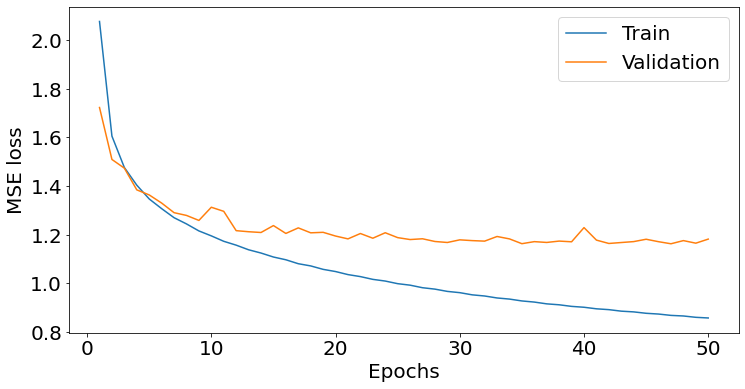

In [ ]:
train_loss = torch.load('/content/drive/My Drive/data_audio/losses/train_loss_dnn.pth')
val_loss = torch.load('/content/drive/My Drive/data_audio/losses/val_loss_dnn.pth')

train_loss = (16/17000)*np.array(train_loss)
val_loss = (16/3000)*np.array(val_loss)

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize = (12, 6))
plt.plot(np.arange(1, 51, 1), train_loss, label = 'Train')
plt.plot(np.arange(1, 51, 1), val_loss, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.legend()

# Qualitative evaluation

In [ ]:
def evaluate_qualitative(net, audio_path, num_example, speech_rate=16000):
  """
  net: MLP model on CPU
  audio_dirs: list of directories containing reverberant spectrograms, clean spectrograms,
              reverberant waveforms and clean waveforms respectively
  num_example: example number in data
  speech_rate: sampling rate of speech data  
  """
  matplotlib.rc('xtick', labelsize=15)  
  matplotlib.rc('ytick', labelsize=15)
  matplotlib.rcParams.update({'font.size': 15})

  waves_rev = torch.load(audio_path[0])
  waves_target = torch.load(audio_path[1])

  rev_spec = generate_spec(waves_rev[num_example], speech_rate)
  clean_spec = generate_spec(waves_target[num_example], speech_rate)

  net.eval()

  ex_rev_norm, ex_data_norm = normalize(rev_spec)
  target_norm, target_data_norm = normalize(clean_spec)

  spec_test0, targets0 = split_specgram(torch.tensor(ex_rev_norm[None,:,:]), torch.tensor(target_norm[None,:,:]))
  spec_test_response = net(spec_test0).cpu().detach().numpy().T

  spec_test_response = spec_test_response*(ex_data_norm[1]+1e-6) + ex_data_norm[0]

  graph_spec(clean_spec)
  graph_spec(rev_spec)
  graph_spec(spec_test_response)

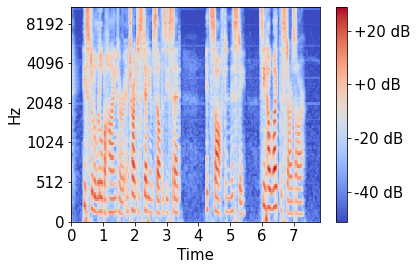

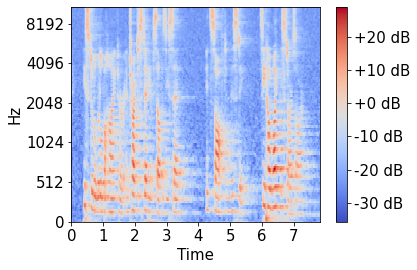

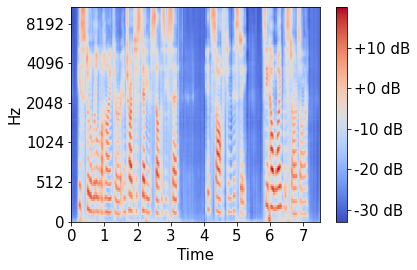

In [ ]:
net = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
net.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', map_location=lambda storage, loc: storage))
path_list = ['/content/drive/My Drive/data_audio/non_norm_data/waverev.pth', '/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth']
evaluate_qualitative(net, path_list, 100)

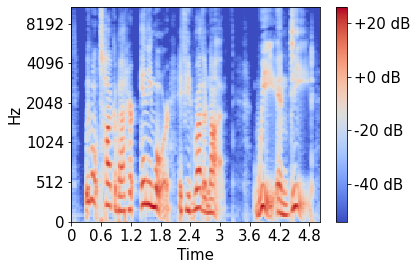

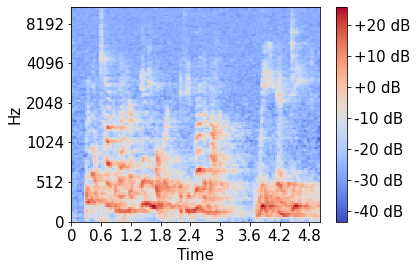

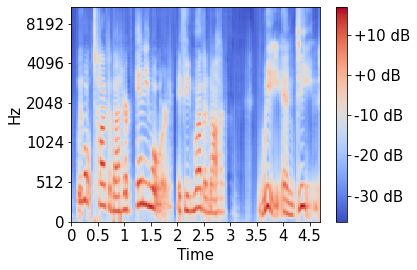

In [ ]:
net = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
net.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', map_location=lambda storage, loc: storage))
path_list = ['/content/drive/My Drive/data_audio/non_norm_data/waverev.pth', '/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth']
evaluate_qualitative(net, path_list, 300)

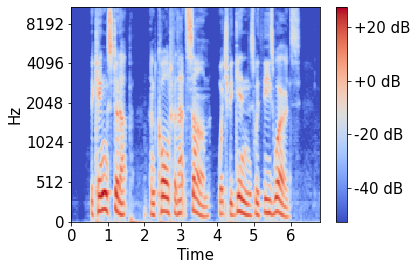

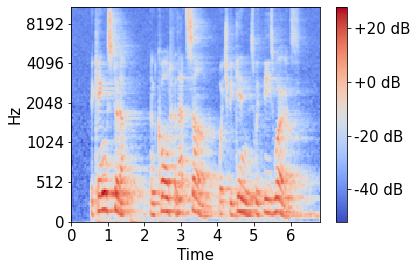

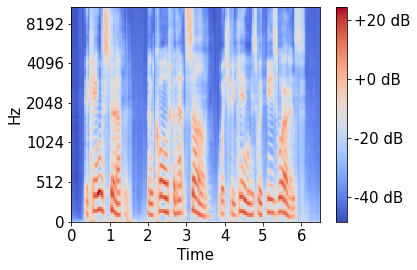

In [ ]:
net = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
net.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', map_location=lambda storage, loc: storage))
path_list = ['/content/drive/My Drive/data_audio/non_norm_data/waverev.pth', '/content/drive/My Drive/data_audio/non_norm_data/wavetarget.pth']
evaluate_qualitative(net, path_list, 400)

In [ ]:
net = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
net.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', map_location=lambda storage, loc: storage))
path_list = ['/content/drive/My Drive/data_audio/non_norm_data/waverev_2.pth', '/content/drive/My Drive/data_audio/non_norm_data/wavetarget_2.pth']
evaluate_qualitative(net, path_list, 310)

# Quantitative evaluation

In [ ]:
!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

     | 2.0MB 1.2MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     | 276kB 49.1MB/s
     | 71kB 46.3MB/s
     - 65.3MB 41kB/s
     |████████████████████████████████| 163kB 7.5MB/s 
  Created wheel for pysepm: filename=pysepm-0.1-cp37-none-any.whl size=24291 sha256=2001737af351b1eceaaf093132c5a9ea479dd55b677079c3d7d519be3d173025
  Stored in directory: /tmp/pip-ephem-wheel-cache-o_bjrc7e/wheels/17/75/23/17712e0da834688ac430e0cf826dd1f7450d0b4873e0269f7c
Successfully built pysepm
  Created wheel for pesq: filename=pesq-0.0.2-cp37-cp37m-linux_x86_64.whl size=162255 sha256=22d41f5c6053a83fd77d1427e40caf95da6d007d823424f583a06a500e57ee1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-o_bjrc7e/wheels/85/91/09/5ae7677a054a05d49111dc8f3b282e886b3852348384893a32
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7781 sha256=a0ada57f066c7532f959277b6ab3ab76f16095790ee7f4a650e4d24d437a6

In [ ]:
!pip install pystoi
!pip install pypesq
from pysepm import llr, cepstrum_distance, fwSNRseg, srmr 
from pystoi import stoi
from pypesq import pesq

  Created wheel for pypesq: filename=pypesq-1.2.4-cp37-cp37m-linux_x86_64.whl size=84244 sha256=1d3c39ee8cc2bedcf8ddb1a5a3d6624cc28b8282b04ee712c09af30c6844d51b
  Stored in directory: /root/.cache/pip/wheels/c9/29/a6/ed19583426cffac50b3e75160f894120a49f9bafa585a2edbe
Successfully built pypesq


In [ ]:
def evaluate(net, path_results, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = True):
  """
  net: MLP model to evaluate
  path_results: base directory to save results
  path_waves: list of 2 paths representing target and reverb waveforms respectively 
  init_example: first example in waveforms to be considered
  end_example: last example in waveforms to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """
   
  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))
 
  if (initial):
    reverb_pesq_list = []
    reverb_stoi_list = []
    reverb_llr_list = []
    reverb_cd_list = []
    reverb_fwSNRseg_list = []
    reverb_srmr_list = []

    dereverb_pesq_list = []
    dereverb_stoi_list = []
    dereverb_llr_list = []
    dereverb_cd_list = []
    dereverb_fwSNRseg_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_pesq_list = torch.load(path_results + 'reverb_pesq_dnn.pth')
    reverb_stoi_list = torch.load(path_results + 'reverb_stoi_dnn.pth')
    reverb_llr_list = torch.load(path_results + 'reverb_llr_dnn.pth')
    reverb_cd_list = torch.load(path_results + 'reverb_cd_dnn.pth')
    reverb_fwSNRseg_list = torch.load(path_results + 'reverb_fwSNRseg_dnn.pth')
    reverb_srmr_list = torch.load(path_results + 'reverb_srmr_dnn.pth')

    dereverb_pesq_list = torch.load(path_results + 'dereverb_pesq_dnn.pth')
    dereverb_stoi_list = torch.load(path_results + 'dereverb_stoi_dnn.pth')
    dereverb_llr_list = torch.load(path_results + 'dereverb_llr_dnn.pth')
    dereverb_cd_list = torch.load(path_results + 'dereverb_cd_dnn.pth')
    dereverb_fwSNRseg_list = torch.load(path_results + 'dereverb_fwSNRseg_dnn.pth')
    dereverb_srmr_list = torch.load(path_results + 'dereverb_srmr_dnn.pth')

  clean_waves = torch.load(path_waves[0])
  rev_waves = torch.load(path_waves[1])
  net.eval()
  for i in range(init_example, end_example):
    print('Processing specgram n°:' + str(i+1))
    real_spec = generate_spec(clean_waves[i], speech_rate)
    rev_spec = generate_spec(rev_waves[i], speech_rate)

    rev_copy = torch.zeros((1, real_spec.shape[0], real_spec.shape[1]))
    target_copy = torch.zeros((1, real_spec.shape[0], real_spec.shape[1]))
    target_copy[0, :, :] = torch.clone(torch.tensor(real_spec))
    rev_copy[0, :, :] = torch.clone(torch.tensor(rev_spec))

    if (normalize_data):
            
      #normalize
      norm_example, norm_stats_rev = normalize(rev_copy[0, :, :].numpy())
      norm_target, norm_stats_target = normalize(target_copy[0, :, :].numpy())
      
      rev_copy_norm = torch.zeros((rev_copy.shape))
      target_copy_norm = torch.zeros((target_copy.shape))
      
      rev_copy_norm[0, :, :] = torch.tensor(norm_example)
      target_copy_norm[0, :, :] = torch.tensor(norm_target)
       
      spec_test, targets = split_specgram(rev_copy_norm, target_copy_norm)  
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
      spec_test_response = spec_test_response*(norm_stats_rev[1] + 1e-6) + norm_stats_rev[0] # denormalize (it doesnt use the target)
      targets = targets*(norm_stats_target[1] + 1e-6) + norm_stats_target[0] # denormalize (it doesnt use the target)
      targets = targets.T

    else:
      spec_test, targets = split_specgram(rev_copy[0, :, :].numpy(), target_copy[0, :, :].numpy())
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
    
    original = reconstruct_wave(targets.numpy())
    reverb = rev_waves[i]
    recon = reconstruct_wave(spec_test_response)
    
    #metrics
    pesq_metric_rev = pesq(clean_waves[i][0:len(reverb)], reverb, speech_rate)
    stoi_metric_rev = stoi(clean_waves[i][0:len(reverb)], reverb, speech_rate)
    llr_metric_rev = llr(clean_waves[i][0:len(reverb)], reverb, speech_rate)
    cd_metric_rev = cepstrum_distance(clean_waves[i][0:len(reverb)], reverb, speech_rate)
    fwSNRseg_metric_rev = fwSNRseg(clean_waves[i][0:len(reverb)], reverb, speech_rate)
    srmr_metric_rev = srmr(reverb, speech_rate)

    pesq_metric_recon = pesq(original[0:len(recon)], recon, fs = speech_rate)
    stoi_metric_recon = stoi(original[0:len(recon)], recon, speech_rate)
    llr_metric_recon = llr(original[0:len(recon)], recon, speech_rate)
    cd_metric_recon = cepstrum_distance(original[0:len(recon)], recon, speech_rate)
    fwSNRseg_metric_recon = fwSNRseg(original[0:len(recon)], recon, speech_rate)
    srmr_metric_recon = srmr(recon, speech_rate)

    reverb_pesq_list.append(pesq_metric_rev)
    reverb_stoi_list.append(stoi_metric_rev)
    reverb_llr_list.append(llr_metric_rev)
    reverb_cd_list.append(cd_metric_rev)
    reverb_fwSNRseg_list.append(fwSNRseg_metric_rev)
    reverb_srmr_list.append(srmr_metric_rev)

    dereverb_pesq_list.append(pesq_metric_recon)
    dereverb_stoi_list.append(stoi_metric_recon)
    dereverb_llr_list.append(llr_metric_recon)
    dereverb_cd_list.append(cd_metric_recon)
    dereverb_fwSNRseg_list.append(fwSNRseg_metric_recon)
    dereverb_srmr_list.append(srmr_metric_recon)

    print('PESQ reverberated signal: {:.3f} || PESQ dereverberated signal: {:.3f}'.format(pesq_metric_rev, pesq_metric_recon))
    print('STOI reverberated signal: {:.3f} || STOI dereverberated signal: {:.3f}'.format(stoi_metric_rev, stoi_metric_recon))
    print('LLR reverberated signal: {:.3f} || LLR dereverberated signal: {:.3f}'.format(llr_metric_rev, llr_metric_recon))
    print('CD reverberated signal: {:.3f} || CD dereverberated signal: {:.3f}'.format(cd_metric_rev, cd_metric_recon))
    print('fwSNRseg reverberated signal: {:.3f} || fwSNRseg dereverberated signal: {:.3f}'.format(fwSNRseg_metric_rev, fwSNRseg_metric_recon))
    print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
    print('\n')

    if ((i+1)%10 == 0):
      torch.save(reverb_pesq_list, path_results + 'reverb_pesq_dnn.pth')
      torch.save(reverb_stoi_list, path_results + 'reverb_stoi_dnn.pth')
      torch.save(reverb_llr_list, path_results + 'reverb_llr_dnn.pth')
      torch.save(reverb_cd_list, path_results + 'reverb_cd_dnn.pth')
      torch.save(reverb_fwSNRseg_list, path_results + 'reverb_fwSNRseg_dnn.pth')
      torch.save(reverb_srmr_list, path_results + 'reverb_srmr_dnn.pth')

      torch.save(dereverb_pesq_list, path_results + 'dereverb_pesq_dnn.pth')
      torch.save(dereverb_stoi_list, path_results + 'dereverb_stoi_dnn.pth')
      torch.save(dereverb_llr_list, path_results + 'dereverb_llr_dnn.pth')
      torch.save(dereverb_cd_list, path_results + 'dereverb_cd_dnn.pth')
      torch.save(dereverb_fwSNRseg_list, path_results + 'dereverb_fwSNRseg_dnn.pth')
      torch.save(dereverb_srmr_list, path_results + 'dereverb_srmr_dnn.pth')
      
      print('Saved')

## Room Simulated 1

In [ ]:
model_dnn = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
model_dnn.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', map_location=lambda storage, loc: storage))
path = '/content/drive/My Drive/metrics_audio/room1/norm_models/'
path_waves = ['/content/drive/My Drive/audio2/non_norm_data/wavetarget.pth', '/content/drive/My Drive/audio2/non_norm_data/waverev.pth']
evaluate(model_dnn, path, path_waves, 0, 500, initial = True, normalize_data = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.241 || PESQ dereverberated signal: 2.222
STOI reverberated signal: 0.840 || STOI dereverberated signal: 0.782
LLR reverberated signal: 0.341 || LLR dereverberated signal: 0.469
CD reverberated signal: 3.498 || CD dereverberated signal: 3.637
fwSNRseg reverberated signal: 9.593 || fwSNRseg dereverberated signal: 8.970
SRMR reverberated signal: 2.961 || SRMR dereverberated signal: 3.307


Processing specgram n°:2
PESQ reverberated signal: 2.171 || PESQ dereverberated signal: 2.240
STOI reverberated signal: 0.808 || STOI dereverberated signal: 0.781
LLR reverberated signal: 0.377 || LLR dereverberated signal: 0.461
CD reverberated signal: 3.738 || CD dereverberated signal: 3.613
fwSNRseg reverberated signal: 8.344 || fwSNRseg dereverberated signal: 8.650
SRMR reverberated signal: 3.543 || SRMR dereverberated signal: 3.293


Processing specgram n°:3
PESQ reverberated signal: 2.146 || PESQ dereverberated signal: 2.174


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_dnn.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_dnn.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_dnn.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_dnn.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_dnn.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_dnn.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_dnn.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_dnn.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_dnn.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_dnn.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.11
STOI: 0.84
LLR: 0.81
CD: 5.39
fwSNRseg: 7.69
SRMR: 3.17

Dereverberated signal:
PESQ: 2.01
STOI: 0.77
LLR: 0.84
CD: 4.95
fwSNRseg: 6.88
SRMR: 3.24


## Room Simulated 2

In [ ]:
model_dnn = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
model_dnn.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', map_location=lambda storage, loc: storage))
path = '/content/drive/My Drive/metrics_audio/room2/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_2.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_2.pth']
evaluate(model_dnn, path, path_waves, 0, 500, initial = True, normalize_data = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.296 || PESQ dereverberated signal: 2.071
STOI reverberated signal: 0.614 || STOI dereverberated signal: 0.638
LLR reverberated signal: 1.095 || LLR dereverberated signal: 1.081
CD reverberated signal: 6.273 || CD dereverberated signal: 5.567
fwSNRseg reverberated signal: 7.129 || fwSNRseg dereverberated signal: 5.833
SRMR reverberated signal: 2.991 || SRMR dereverberated signal: 1.981


Processing specgram n°:2
PESQ reverberated signal: 2.240 || PESQ dereverberated signal: 2.182
STOI reverberated signal: 0.670 || STOI dereverberated signal: 0.682
LLR reverberated signal: 1.256 || LLR dereverberated signal: 0.993
CD reverberated signal: 6.942 || CD dereverberated signal: 5.276
fwSNRseg reverberated signal: 6.317 || fwSNRseg dereverberated signal: 6.064
SRMR reverberated signal: 2.799 || SRMR dereverberated signal: 2.048


Processing specgram n°:3
PESQ reverberated signal: 2.191 || PESQ dereverberated signal: 1.903


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_dnn.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_dnn.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_dnn.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_dnn.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_dnn.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_dnn.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_dnn.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_dnn.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_dnn.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_dnn.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.15
STOI: 0.67
LLR: 0.97
CD: 5.71
fwSNRseg: 6.58
SRMR: 4.49

Dereverberated signal:
PESQ: 1.87
STOI: 0.64
LLR: 1.07
CD: 5.62
fwSNRseg: 5.82
SRMR: 2.81


## Room Simulated 3

In [ ]:
model_dnn = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
model_dnn.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', map_location=lambda storage, loc: storage))
path = '/content/drive/My Drive/metrics_audio/room3/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_3.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_3.pth']
evaluate(model_dnn, path, path_waves, 0, 500, initial = True, normalize_data = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.574 || PESQ dereverberated signal: 2.168
STOI reverberated signal: 0.762 || STOI dereverberated signal: 0.754
LLR reverberated signal: 1.021 || LLR dereverberated signal: 1.044
CD reverberated signal: 6.051 || CD dereverberated signal: 5.594
fwSNRseg reverberated signal: 9.153 || fwSNRseg dereverberated signal: 6.754
SRMR reverberated signal: 3.481 || SRMR dereverberated signal: 2.433


Processing specgram n°:2
PESQ reverberated signal: 2.540 || PESQ dereverberated signal: 2.277
STOI reverberated signal: 0.799 || STOI dereverberated signal: 0.791
LLR reverberated signal: 1.174 || LLR dereverberated signal: 0.987
CD reverberated signal: 6.630 || CD dereverberated signal: 5.280
fwSNRseg reverberated signal: 7.911 || fwSNRseg dereverberated signal: 6.531
SRMR reverberated signal: 3.663 || SRMR dereverberated signal: 2.464


Processing specgram n°:3
PESQ reverberated signal: 2.588 || PESQ dereverberated signal: 2.167


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_dnn.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_dnn.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_dnn.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_dnn.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_dnn.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_dnn.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_dnn.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_dnn.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_dnn.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_dnn.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.57
STOI: 0.83
LLR: 0.85
CD: 5.25
fwSNRseg: 8.68
SRMR: 5.21

Dereverberated signal:
PESQ: 2.09
STOI: 0.77
LLR: 1.02
CD: 5.48
fwSNRseg: 6.72
SRMR: 3.13


## Room Simulated 4

In [ ]:
model_dnn = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
model_dnn.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', map_location=lambda storage, loc: storage))
path = '/content/drive/My Drive/metrics_audio/room4/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_4.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_4.pth']
evaluate(model_dnn, path, path_waves, 0, 500, initial = True, normalize_data = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.372 || PESQ dereverberated signal: 2.166
STOI reverberated signal: 0.832 || STOI dereverberated signal: 0.795
LLR reverberated signal: 0.413 || LLR dereverberated signal: 0.583
CD reverberated signal: 3.930 || CD dereverberated signal: 4.034
fwSNRseg reverberated signal: 8.718 || fwSNRseg dereverberated signal: 7.485
SRMR reverberated signal: 2.446 || SRMR dereverberated signal: 3.883


Processing specgram n°:2
PESQ reverberated signal: 2.439 || PESQ dereverberated signal: 2.199
STOI reverberated signal: 0.852 || STOI dereverberated signal: 0.793
LLR reverberated signal: 0.530 || LLR dereverberated signal: 0.550
CD reverberated signal: 4.465 || CD dereverberated signal: 3.938
fwSNRseg reverberated signal: 9.210 || fwSNRseg dereverberated signal: 7.724
SRMR reverberated signal: 2.231 || SRMR dereverberated signal: 3.072


Processing specgram n°:3
PESQ reverberated signal: 2.346 || PESQ dereverberated signal: 2.079


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_dnn.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_dnn.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_dnn.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_dnn.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_dnn.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_dnn.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_dnn.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_dnn.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_dnn.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_dnn.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.17
STOI: 0.85
LLR: 0.59
CD: 4.69
fwSNRseg: 8.12
SRMR: 3.15

Dereverberated signal:
PESQ: 2.18
STOI: 0.80
LLR: 0.59
CD: 4.16
fwSNRseg: 7.74
SRMR: 3.94


## Simulated room 5

In [ ]:
model_dnn = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
model_dnn.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', map_location=lambda storage, loc: storage))
path = '/content/drive/My Drive/metrics_audio/room5/norm_models/'
path_waves = ['/content/drive/My Drive/data_audio/non_norm_data/wavetarget_5.pth', '/content/drive/My Drive/data_audio/non_norm_data/waverev_5.pth']
evaluate(model_dnn, path, path_waves, 0, 500, initial = True, normalize_data = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 1.951 || PESQ dereverberated signal: 1.549
STOI reverberated signal: 0.760 || STOI dereverberated signal: 0.700
LLR reverberated signal: 1.263 || LLR dereverberated signal: 1.337
CD reverberated signal: 6.593 || CD dereverberated signal: 6.329
fwSNRseg reverberated signal: 5.571 || fwSNRseg dereverberated signal: 4.258
SRMR reverberated signal: 3.246 || SRMR dereverberated signal: 2.234


Processing specgram n°:2
PESQ reverberated signal: 1.884 || PESQ dereverberated signal: 1.726
STOI reverberated signal: 0.771 || STOI dereverberated signal: 0.708
LLR reverberated signal: 1.256 || LLR dereverberated signal: 1.378
CD reverberated signal: 6.778 || CD dereverberated signal: 6.647
fwSNRseg reverberated signal: 6.492 || fwSNRseg dereverberated signal: 4.586
SRMR reverberated signal: 3.948 || SRMR dereverberated signal: 2.240


Processing specgram n°:3
PESQ reverberated signal: 2.040 || PESQ dereverberated signal: 1.857


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room5/norm_models/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_dnn.pth')
reverb_stoi_list = torch.load(path + 'reverb_stoi_dnn.pth')
reverb_llr_list = torch.load(path + 'reverb_llr_dnn.pth')
reverb_cd_list = torch.load(path + 'reverb_cd_dnn.pth')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_dnn.pth')
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn.pth')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_dnn.pth')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_dnn.pth')
dereverb_llr_list = torch.load(path + 'dereverb_llr_dnn.pth')
dereverb_cd_list = torch.load(path + 'dereverb_cd_dnn.pth')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_dnn.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn.pth')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 1.97
STOI: 0.80
LLR: 1.36
CD: 7.30
fwSNRseg: 6.38
SRMR: 3.08

Dereverberated signal:
PESQ: 1.66
STOI: 0.71
LLR: 1.38
CD: 6.84
fwSNRseg: 5.04
SRMR: 2.06


In [ ]:
def evaluate_realdata(net, path_results, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = True):
  """
  net: MLP based model to evaluate
  path_results: base directory to save results
  path_waves: path representing reverb waveforms 
  init_example: first example in dataset to be considered
  end_example: last example in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """

  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))
 
  if (initial):
    reverb_srmr_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_srmr_list = torch.load(path_results + 'reverb_srmr_dnn.pth')
    dereverb_srmr_list = torch.load(path_results + 'dereverb_srmr_dnn.pth')

  waves = torch.load(path_waves)
  net.eval()
  for i in range(init_example, end_example):
    print('Processing specgram n°:' + str(i+1))
    real_spec = generate_spec(waves[i], speech_rate)
    rev_copy = torch.zeros((1, real_spec.shape[0], real_spec.shape[1]))
    rev_copy[0, :, :] = torch.clone(torch.tensor(real_spec))
    if (normalize_data):
            
      #normalize
      norm_example, norm_stats_rev = normalize(rev_copy[0, :, :].numpy())      
      rev_copy_norm = torch.zeros((rev_copy.shape))    
      rev_copy_norm[0, :, :] = torch.tensor(norm_example)
  
      spec_test = split_realdata(rev_copy_norm) 
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
      spec_test_response = spec_test_response*(norm_stats_rev[1] + 1e-6) + norm_stats_rev[0] # denormalize (it doesnt use the target)

    else:
      spec_test = split_realdata(rev_copy[0, :, :].numpy())
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
    
    #SRMR evaluation
    recon = reconstruct_wave(spec_test_response)
    
    srmr_metric_rev = srmr(waves[i], speech_rate)
    srmr_metric_recon = srmr(recon, speech_rate)

    reverb_srmr_list.append(srmr_metric_rev)
    dereverb_srmr_list.append(srmr_metric_recon)

    print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
    print('\n')

    if ((i+1)%10 == 0):

      torch.save(reverb_srmr_list, path_results + 'reverb_srmr_dnn.pth')
      torch.save(dereverb_srmr_list, path_results + 'dereverb_srmr_dnn.pth')
      
      print('Saved')

## Real far data

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/norm_models/'
path_waves = '/content/drive/My Drive/real_data/waves2.pth'
model_dnn = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
model_dnn.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', map_location=lambda storage, loc: storage))

evaluate_realdata(model_dnn, path, path_waves, 0, 500, initial = True, normalize_data=True)

Current device: cpu
Processing specgram n°:1
SRMR reverberated signal: 3.544 || SRMR dereverberated signal: 5.921


Processing specgram n°:2
SRMR reverberated signal: 5.083 || SRMR dereverberated signal: 4.804


Processing specgram n°:3
SRMR reverberated signal: 4.067 || SRMR dereverberated signal: 5.791


Processing specgram n°:4
SRMR reverberated signal: 3.647 || SRMR dereverberated signal: 4.459


Processing specgram n°:5
SRMR reverberated signal: 5.406 || SRMR dereverberated signal: 5.066


Processing specgram n°:6
SRMR reverberated signal: 3.478 || SRMR dereverberated signal: 4.519


Processing specgram n°:7
SRMR reverberated signal: 5.542 || SRMR dereverberated signal: 4.162


Processing specgram n°:8
SRMR reverberated signal: 2.970 || SRMR dereverberated signal: 3.865


Processing specgram n°:9
SRMR reverberated signal: 7.028 || SRMR dereverberated signal: 5.010


Processing specgram n°:10
SRMR reverberated signal: 5.625 || SRMR dereverberated signal: 5.317


Saved
Processing sp

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/norm_models/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn.pth')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 4.36

Dereverberated signal:
SRMR: 5.53


# Near real data

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/norm_models/'
path_waves = '/content/drive/My Drive/real_data/waves1.pth'
model_dnn = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
model_dnn.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', map_location=lambda storage, loc: storage))

evaluate_realdata(model_dnn, path, path_waves, 0, 500, initial = True, normalize_data=True)

Current device: cpu
Processing specgram n°:1
SRMR reverberated signal: 2.644 || SRMR dereverberated signal: 3.047


Processing specgram n°:2
SRMR reverberated signal: 2.455 || SRMR dereverberated signal: 3.385


Processing specgram n°:3
SRMR reverberated signal: 3.125 || SRMR dereverberated signal: 2.678


Processing specgram n°:4
SRMR reverberated signal: 2.727 || SRMR dereverberated signal: 3.119


Processing specgram n°:5
SRMR reverberated signal: 2.833 || SRMR dereverberated signal: 2.949


Processing specgram n°:6
SRMR reverberated signal: 3.089 || SRMR dereverberated signal: 4.377


Processing specgram n°:7
SRMR reverberated signal: 2.542 || SRMR dereverberated signal: 4.501


Processing specgram n°:8
SRMR reverberated signal: 2.694 || SRMR dereverberated signal: 4.414


Processing specgram n°:9
SRMR reverberated signal: 2.502 || SRMR dereverberated signal: 3.644


Processing specgram n°:10
SRMR reverberated signal: 4.001 || SRMR dereverberated signal: 3.899


Saved
Processing sp

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/norm_models/'
path_waves = '/content/drive/My Drive/real_data/waves1.pth'
model_dnn = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
model_dnn.load_state_dict(torch.load('/content/drive/My Drive/data_audio/models/dnn_state_dict.pth', map_location=lambda storage, loc: storage))

evaluate_realdata(model_dnn, path, path_waves, 50, 500, initial = False, normalize_data=True)

Current device: cpu
Processing specgram n°:51
SRMR reverberated signal: 5.850 || SRMR dereverberated signal: 7.590


Processing specgram n°:52
SRMR reverberated signal: 3.827 || SRMR dereverberated signal: 6.160


Processing specgram n°:53
SRMR reverberated signal: 7.125 || SRMR dereverberated signal: 8.258


Processing specgram n°:54
SRMR reverberated signal: 4.871 || SRMR dereverberated signal: 8.155


Processing specgram n°:55
SRMR reverberated signal: 4.943 || SRMR dereverberated signal: 6.695


Processing specgram n°:56
SRMR reverberated signal: 4.139 || SRMR dereverberated signal: 4.852


Processing specgram n°:57
SRMR reverberated signal: 6.465 || SRMR dereverberated signal: 8.801


Processing specgram n°:58
SRMR reverberated signal: 4.345 || SRMR dereverberated signal: 7.243


Processing specgram n°:59
SRMR reverberated signal: 5.106 || SRMR dereverberated signal: 9.330


Processing specgram n°:60
SRMR reverberated signal: 7.407 || SRMR dereverberated signal: 10.185


Saved
Pro

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/norm_models/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn.pth')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn.pth')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 3.99

Dereverberated signal:
SRMR: 4.69
